# *Machine Learning Approach*

## Imports 

In [1]:
import kagglehub
from requests.exceptions import ChunkedEncodingError
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from skimage import exposure
import matplotlib.pyplot as plt
import joblib
import os
import cv2
import numpy as np
import pickle
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

/home/user_stel/image_assignment_2/image_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


For this part of the assignment we will use classical machine Learning techniques, using the HOG features we extracted earlier. This task is transformed into a binary classification task. We will tune various classifiers using 5-fold cross validation and then we will train and test those tuned classifiers in order to select te best performing one. This problem could be adressed in two sections, the first section revolves around the classification of images between 2 classes; normal and pneumonia and the second section can be considered as a binary classification task as well, within the pneumonia class, between 2 classes: viral and bacterial pneumonia.  

## Load Data

Both train and test data have been preprocessed. Data consists  of HOG features and target column which represents the class labels. 0 for Normal, 1 for Pneumonia. 

In [2]:
with open("/home/user_stel/image_assignment_2/data_ml/train_data.pkl", "rb") as f:
    train_data = pickle.load(f)

X_tr, y_tr = zip(*train_data)
X_tr = np.array(X_tr)
y_tr = np.array(y_tr)

with open("/home/user_stel/image_assignment_2/data_ml/test_data.pkl", "rb") as f:
    test_data = pickle.load(f)

X_te, y_te = zip(*test_data)
X_te = np.array(X_te)
y_te = np.array(y_te)

## Hyperparameter Tuning using 5-fold Cross Validation

Using 5-fold cross validation on our processed (and labeled) train dataset, we will tune 3 different classifiers, the Support Vector Machines (for the Support Vector Machines we eill treat the linear and rbf kernels as separate model instances), the Random Forests and the Logistic Regression. Our aim is to find the optimal set of hyperparameters for each classifier and to save the best model instance of each classifier, which we will evaluate using our test dataset later on. 

In [3]:
# Define classifiers and hyperparameters
models = {
    "SVM (RBF)": (SVC(), {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto']
    }),
    "SVM (Linear)": (SVC(kernel='linear'), {
        'C': [0.1, 1, 10]
    }),
    "Random Forest": (RandomForestClassifier(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20]
    }),
    "Logistic Regression": (LogisticRegression(max_iter=1000), {
        'C': [0.01, 0.1, 1, 10]
    }),
}

In [4]:
def model_tuning(X, y, models, cmap, test_size=0.2, random_state=42, verbose=True):
    """
    Trains and tunes models using GridSearchCV, evaluates on test set,
    and displays confusion matrix plots.

    Parameters:
        X (np.ndarray): Feature matrix
        y (np.ndarray): Target vector
        models (dict): {name: (model, param_grid)}
        test_size (float): Fraction of data for testing
        random_state (int): Random seed
        verbose (bool): Whether to print detailed output

    Returns:
        best_models (dict): {model_name: (best_model, test_accuracy)}
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    best_models = {}

    for name, (model, param_grid) in models.items():
        if verbose:
            print(f"\n🔍 Training {name}...")

        grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        if verbose:
            print(f"✅ {name} Accuracy: {acc:.4f}")
            print("Best Parameters:", grid.best_params_)
            print("Classification Report:\n", classification_report(y_test, y_pred))

        # Confusion matrix and heatmap
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
        plt.title(f'Confusion Matrix: {name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        best_models[name] = (best_model, acc)

    return best_models


🔍 Training SVM (RBF)...
✅ SVM (RBF) Accuracy: 0.9780
Best Parameters: {'C': 10, 'gamma': 'scale'}
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       268
           1       0.99      0.98      0.99       776

    accuracy                           0.98      1044
   macro avg       0.97      0.97      0.97      1044
weighted avg       0.98      0.98      0.98      1044



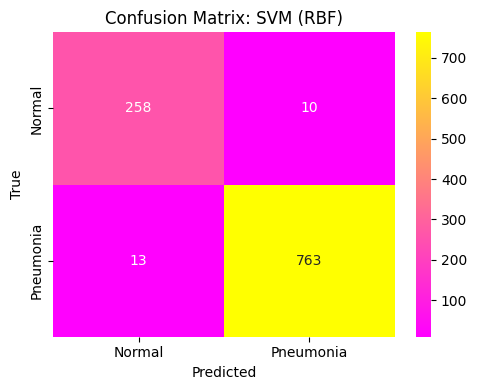


🔍 Training SVM (Linear)...
✅ SVM (Linear) Accuracy: 0.9761
Best Parameters: {'C': 0.1}
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95       268
           1       0.99      0.97      0.98       776

    accuracy                           0.98      1044
   macro avg       0.96      0.98      0.97      1044
weighted avg       0.98      0.98      0.98      1044



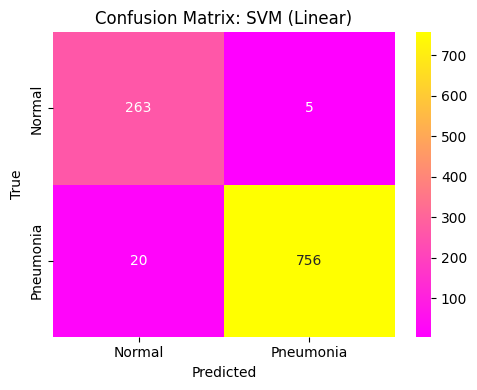


🔍 Training Random Forest...
✅ Random Forest Accuracy: 0.9636
Best Parameters: {'max_depth': None, 'n_estimators': 200}
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93       268
           1       0.97      0.98      0.98       776

    accuracy                           0.96      1044
   macro avg       0.96      0.94      0.95      1044
weighted avg       0.96      0.96      0.96      1044



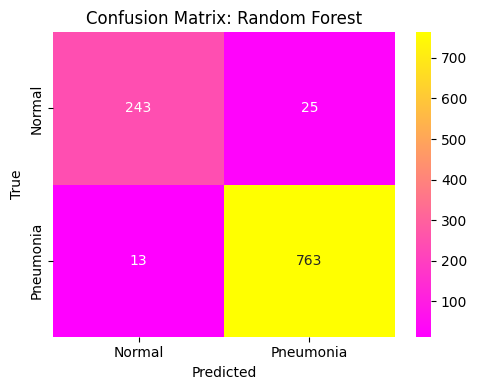


🔍 Training Logistic Regression...
✅ Logistic Regression Accuracy: 0.9732
Best Parameters: {'C': 1}
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95       268
           1       0.99      0.98      0.98       776

    accuracy                           0.97      1044
   macro avg       0.96      0.97      0.97      1044
weighted avg       0.97      0.97      0.97      1044



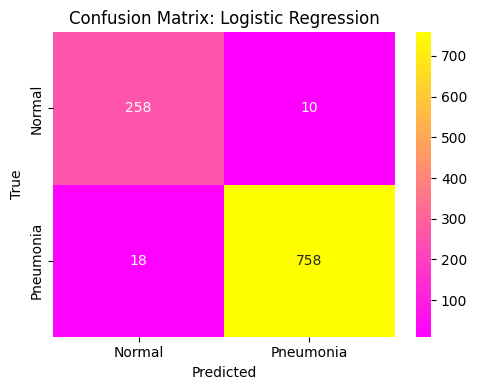

In [9]:
best_models = model_tuning(X=X_tr, y=y_tr, cmap='spring', models=models)

### Save Tuned Model Instances

In [ ]:
print(best_models)

# Save each best model from the returned dictionary
for model_name, (model_instance, acc) in best_models.items():
    filename = f"{model_name.replace(' ', '_').replace('(', '').replace(')', '')}_model.pkl"
    joblib.dump(model_instance, filename)
    print(f"✅ Saved {model_name} to {filename}")


{'SVM (RBF)': (SVC(C=10), 0.9779693486590039), 'SVM (Linear)': (SVC(C=0.1, kernel='linear'), 0.9760536398467433), 'Random Forest': (RandomForestClassifier(n_estimators=200), 0.9636015325670498), 'Logistic Regression': (LogisticRegression(C=1, max_iter=1000), 0.9731800766283525)}
✅ Saved SVM (RBF) to SVM_RBF_model.pkl
✅ Saved SVM (Linear) to SVM_Linear_model.pkl
✅ Saved Random Forest to Random_Forest_model.pkl
✅ Saved Logistic Regression to Logistic_Regression_model.pkl


## Evaluate Tuned Models 

The tuned models will be trained using the whole training dataset and evaluated on the whole test dataset. The results will be compared with the reults obtained from the Neural Networks approach in order to determine which approach managed to uncover the true underlying pattern of the data. 

In [6]:
log_model = joblib.load("/home/user_stel/image_assignment_2/tuned_models/Logistic_Regression_model.pkl")
rf_model = joblib.load("/home/user_stel/image_assignment_2/tuned_models/Random_Forest_model.pkl")
svm_lin_model = joblib.load("/home/user_stel/image_assignment_2/tuned_models/SVM_Linear_model.pkl")
svm_rbf_model = joblib.load("/home/user_stel/image_assignment_2/tuned_models/SVM_RBF_model.pkl")

In [9]:
def model_evaluating(model, X_train, y_train, X_test, y_test, cmap, model_name="Model"):
    """
    Trains the model on full training data and evaluates on test data.
    Prints accuracy, classification report, and plots confusion matrix.

    Parameters:
        model: A scikit-learn model instance (not yet trained)
        X_train (np.ndarray): Training feature matrix
        y_train (np.ndarray): Training labels
        X_test (np.ndarray): Test feature matrix
        y_test (np.ndarray): Test labels
        model_name (str): Name of the model for display

    Returns:
        dict: Evaluation results including accuracy, confusion matrix, and classification report
    """
    # Train the model
    model.fit(X_train, y_train)

    # Predict on test data
    y_pred = model.predict(X_test)

    # Evaluation
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Display
    print(f"📊 Evaluation Results - {model_name}")
    print(f"✅ Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix heatmap
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=["Normal", "Pneumonia"],
                yticklabels=["Normal", "Pneumonia"])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    return {
        "model": model,
        "accuracy": acc,
        "confusion_matrix": cm,
        "classification_report": report
    }

📊 Evaluation Results - Logistic Regression
✅ Accuracy: 0.7628
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.37      0.54       234
           1       0.72      1.00      0.84       390

    accuracy                           0.76       624
   macro avg       0.86      0.68      0.69       624
weighted avg       0.83      0.76      0.73       624



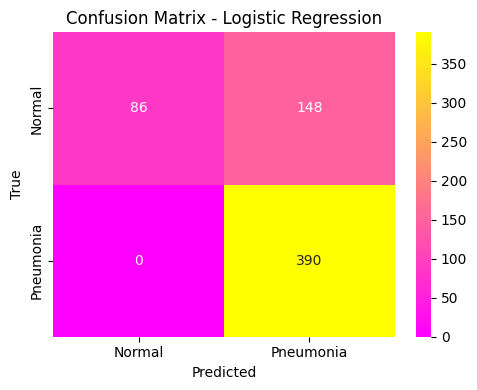

In [10]:
log_reg_results = model_evaluating(model=log_model, X_train=X_tr, y_train=y_tr, X_test=X_te, y_test=y_te, cmap = 'spring', model_name="Logistic Regression")

📊 Evaluation Results - Random Forests
✅ Accuracy: 0.7003
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.21      0.34       234
           1       0.68      0.99      0.81       390

    accuracy                           0.70       624
   macro avg       0.82      0.60      0.57       624
weighted avg       0.78      0.70      0.63       624



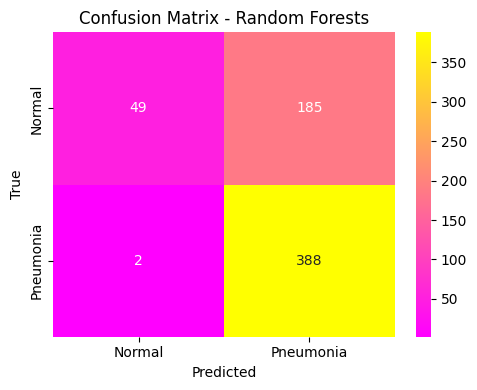

In [12]:
rf_results = model_evaluating(model=rf_model, X_train=X_tr, y_train=y_tr, X_test=X_te, y_test=y_te, cmap = 'spring', model_name="Random Forests")

📊 Evaluation Results - SVM using Linear Kernel
✅ Accuracy: 0.7580
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.36      0.53       234
           1       0.72      1.00      0.84       390

    accuracy                           0.76       624
   macro avg       0.85      0.68      0.68       624
weighted avg       0.82      0.76      0.72       624



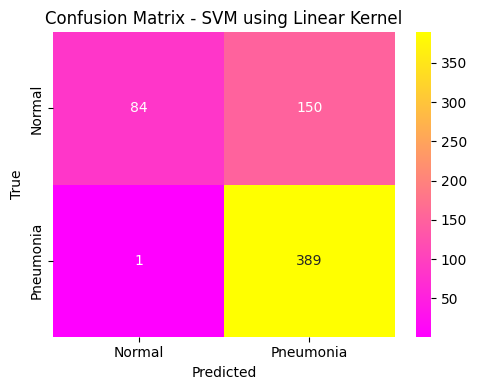

In [13]:
svm_lin_results = model_evaluating(model=svm_lin_model, X_train=X_tr, y_train=y_tr, X_test=X_te, y_test=y_te, cmap = 'spring', model_name="SVM using Linear Kernel")

📊 Evaluation Results - SVM using RBF Kernel
✅ Accuracy: 0.7740
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.40      0.57       234
           1       0.74      1.00      0.85       390

    accuracy                           0.77       624
   macro avg       0.86      0.70      0.71       624
weighted avg       0.83      0.77      0.74       624



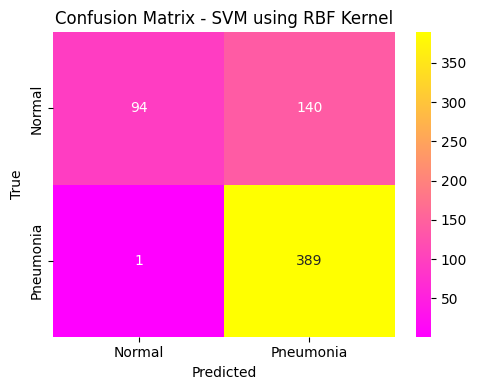

In [14]:
svm_rbf_results = model_evaluating(model=svm_rbf_model, X_train=X_tr, y_train=y_tr, X_test=X_te, y_test=y_te, cmap = 'spring', model_name="SVM using RBF Kernel")

## Results Interpretation

Out of all 3 algorithms and all model instances the one that achieved the highest accuracy score in the evaluation process using the test dataset, was the Support Vector Machines classifier with the rbf kernel and these hyperparameters; 'SVM (RBF)': (SVC(C=10), 0.9779693486590039)'. The highest score to be compared with the results of the Neural Networks approach is the *0.7740*. A general observation across all models is their evidently higher success in correctly identifying Pneumonia images. There is a clear tendency toward favoring the Pneumonia class (class 1), as the majority of misclassifications involved Normal images being incorrectly labeled as Pneumonia.